## DBSCAN Clustering and Dendogram using Iris dataset

This notebook explores DBSCAN clustering algorithm and Dendograms. 
We will use the `Iris` flower dataset which is used to identify types of flowers based on features describing their petals. 


After loading the dataset, we will extract two of the attributes and will run the K-means algorithm to obtain 3 clusters. 

### 1. Importing the dataset
We will load the dataset directly from the ```scikit-learn``` machine learning library.. We will also print the description of the iris dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# import the iris dataset
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

The dataset consists of samples described by four predictor attributes - sepal length, sepal width, petal length, petal width, in centimeters and a label which can take on three discrete values Iris-Setosa, Iris-Versicolour and Iris-Virginica. 

First we will only work with the first two attributes sepal length and sepal width, which will be stored in the variable X.

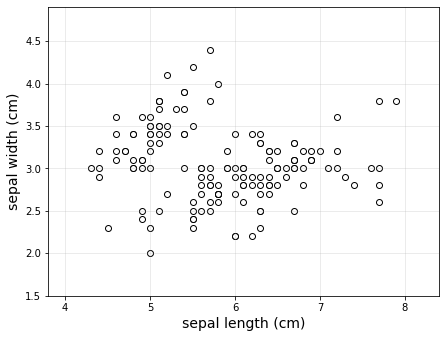

In [2]:
X = iris.data[:, :2] 
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

ax.scatter(X[:, 0], X[:, 1], edgecolor='black', c = 'w')

ax.set_xlabel(iris.feature_names[0], fontsize=14)
ax.set_ylabel(iris.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
plt.show()

### 2. DBSCAN clustering algorithm (Density Based Spatial Clustering of Applications with Noise)

The DBSCAN algorithm builds clusters based on the notion of connectivity. We first visualise a clustering solution on the 2D space formed by the `sepal length` and the `sepal width` attributes. In addition to 2 clusters (red and blue samples), DBSCAN returns outlier samples that are not assigned to any cluster.

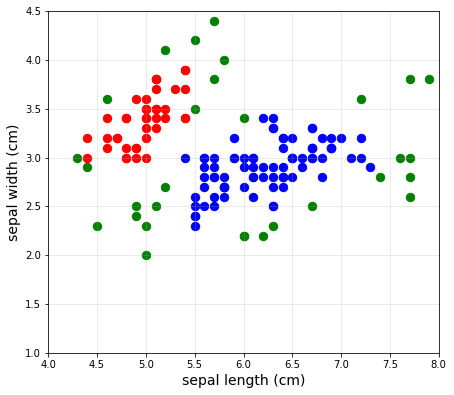

In [3]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.25, min_samples=8).fit(X[:,:2])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

colors = ("red", "blue", "green")
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.set_xlabel(iris.feature_names[0], fontsize=14)
ax.set_ylabel(iris.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(4, 8)
ax.set_ylim(1, 4.5)

for l in [-1, 0, 1]:
  ax.scatter(X[labels == l, 0], X[labels == l, 1],
             s=70, c=colors[l])

DBSCAN proceeds by obtaining the density of samples around each sample. The density is estimated by counting the number of samples within a given radius. If this number is greater than a pre-specified threshold, DBSCAN treats the sample as a core sample, otherwise it will be a border sample. 

Different thresholds produce different solutions. In the code below, we obtain and plot the number of clusters and outliers identified by DBSCAN for different threshold values. Note that the 4 attributes of the dataset are used by DBSCAN.

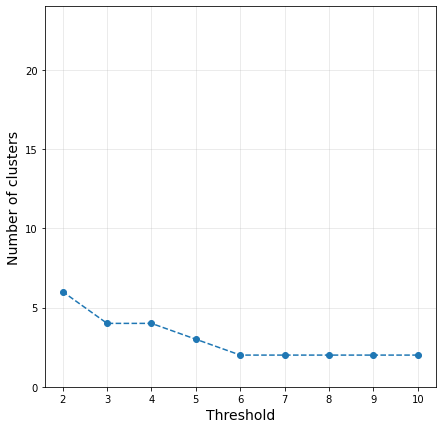

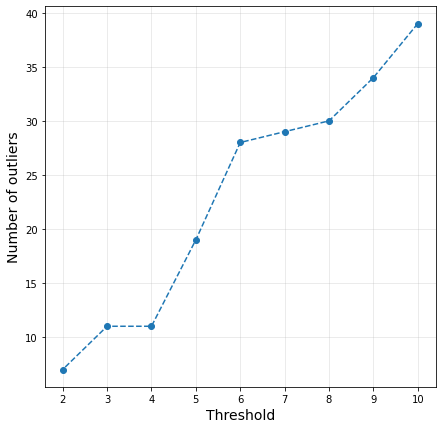

In [4]:
number_of_samples_threshold = np.array([10, 9, 8, 7, 6, 5, 4, 3, 2])
number_of_clusters = []
number_of_outliers = []

for s in number_of_samples_threshold: 
    db = DBSCAN(eps=0.25, min_samples=s).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers_ = list(labels).count(-1)

    number_of_clusters.append(n_clusters_)
    number_of_outliers.append(n_outliers_)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

ax.set_xlabel("Threshold", fontsize=14)
ax.set_ylabel("Number of clusters", fontsize=14)
ax.grid(alpha=0.3)
ax.set_ylim(0,24)
ax.plot(number_of_samples_threshold, number_of_clusters, '--', marker = 'o')


fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

ax.set_xlabel("Threshold", fontsize=14)
ax.set_ylabel("Number of outliers", fontsize=14)
ax.grid(alpha=0.3)
ax.plot(number_of_samples_threshold, number_of_outliers, '--', marker = 'o')


We can see that the number of clusters decrease as we increase the threshold. In order to make sense of this, we need to look at the number of outliers too. We also have to remember that the dataset consists of 150 samples.

### 3. Hierarchical clustering

Hierarchical clustering builds clustering arrangements at different levels. The code below imports and defines functions that we will use to apply an agglomerative clustering algorithm and visualise its solution.

In [5]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Applying an agglomerative clustering algorithm on the iris dataset.

In [6]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
IrisAggmodel = model.fit(X)

Obtaining the resulting dendrogram.

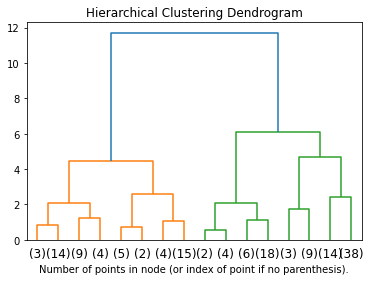

In [7]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(IrisAggmodel, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Branching in the dendrogram represents one of the clusters at one level being split. We can see that 16 clusters have been identified at the lowest level (In some instances index of index of one or more points may be shown if the notebook is run again). 

The dendrogram includes the number of samples in each cluster at the lowest level between parenthesis or the sample index if the cluster consists of just one sample. The number of samples in each clusters add up to 150.

### 4. Conclusions
 
In this notebook, we have explored two clustering algorithms. We have applied DBSCAN and an agglomerative clustering approach. We have also seen how changing the threshold in DBSCAN produces different clustering solutions. Finally, we have visualised a dendrogram for the agglomerative hierarchical algorithm.  